> __Purpose:__ This NB visualizes the results of the full study for various finetuning approaches. Need to add hyperparam tuning... maybe turn off Earlystopping?

In [1]:
import numpy as np
#from sklearn.preprocessing import LabelEncoder
#import matplotlib.pyplot as plt
#import pandas as pd

from global_seed import set_seed
set_seed()

from agglo_model_clust import *
from cluster_acc_viz_funcs import *
from DNN_FT_funcs import *
from DNN_AMC_funcs import *
from full_study_funcs import *
from revamped_model_classes import *
from hyperparam_tuned_configs import *

import os
cwd = os.getcwd()
print("Current Working Directory: ", cwd)


Global seed set to 17
Current Working Directory:  c:\Users\kdmen\Repos\fl-gestures\April_25


In [2]:

MODEL_STR = "OriginalELEC573CNN"
MY_CONFIG = OriginalELEC573CNN_config

MY_CONFIG["user_split_json_filepath"] = "fixed_user_splits\\24_8_user_splits_RS17.json"

NUM_MONTE_CARLO_RUNS = 1
SAVE_FIGS = False
timestamp = datetime.now().strftime("%Y%m%d_%H%M")


In [3]:
expdef_df = load_expdef_gestures(feateng_method=MY_CONFIG["feature_engr"])

print(expdef_df.shape)
expdef_df.head()

(3200, 6)


,Participant,Gesture_ID,Gesture_Num,feature,Gesture_Encoded,Cluster_ID
0,P004,close,1,"[[6.079045311063784], [-7.551458873254243], [-...",0,0
1,P004,close,10,"[[5.994789910363704], [-7.978871468164499], [-...",0,0
2,P004,close,2,"[[6.010193380499154], [-7.7063875553339], [-20...",0,0
3,P004,close,3,"[[5.8212078257286874], [-7.463908156909893], [...",0,0
4,P004,close,4,"[[5.974675085061773], [-7.945111601415482], [-...",0,0


In [4]:
# Load the CLUSTERING RESULTS DATA
with open('C:\\Users\\kdmen\\Repos\\fl-gestures\\April_25\\results\\clustering_models\\20250219_1342\\248_RS17_OriginalELEC573CNN_agglo_merge_res.pkl', 'rb') as f:
    merge_log = pickle.load(f)
    intra_cluster_performance = pickle.load(f)
    cross_cluster_performance = pickle.load(f)
    nested_clus_model_dict = pickle.load(f)

print("Data has been loaded successfully!")

Data has been loaded successfully!


In [5]:
full_path = os.path.join("C:\\Users\\kdmen\\Repos\\fl-gestures\\April_25\\models\\20250219_1327", '248_RS17_pretrained_OriginalELEC573CNN_model.pth')

print("Full Path:", full_path)
# Load the pretrained model
pretrained_generic_model = select_model(MODEL_STR, MY_CONFIG)
pretrained_generic_model.load_state_dict(torch.load(full_path))

Full Path: C:\Users\kdmen\Repos\fl-gestures\April_25\models\20250219_1327\248_RS17_pretrained_OriginalELEC573CNN_model.pth


<All keys matched successfully>

In [6]:
import json
# Load the fixed user splits
with open("fixed_user_splits\\24_8_user_splits_RS17.json", "r") as f:
    splits = json.load(f)
all_participants = splits["all_users"]
test_participants = splits["test_users"]


In [7]:
#"finetune_strategy": "progressive_unfreeze",
#    - "full": Train the entire model.
#    - "freeze_cnn": Freeze CNN, train LSTM and dense layers.
#    - "freeze_all_but_final_dense": Freeze CNN + LSTM, train only dense layers.
#    - "progressive_unfreeze": Start with frozen CNN/LSTM, progressively unfreeze.

progunfreezingFT_config = copy.deepcopy(MY_CONFIG)

# The below two are also basically the same... slighly different hyperparams...

originalELEC573FT_config = copy.deepcopy(MY_CONFIG)
#OriginalELEC573CNN_config["use_earlystopping"] = False
#OriginalELEC573CNN_config["lr_scheduler_patience"] = 10000
#OriginalELEC573CNN_config["lr_scheduler_factor"] = 0.0
#OriginalELEC573CNN_config["earlystopping_patience"] = 10000
#OriginalELEC573CNN_config["earlystopping_min_delta"] = 0.01
#OriginalELEC573CNN_config["ft_lr_scheduler_patience"] = 10000 
#OriginalELEC573CNN_config["ft_lr_scheduler_factor"] = 0.1
#OriginalELEC573CNN_config["ft_earlystopping_patience"] = 10000
#OriginalELEC573CNN_config["ft_earlystopping_min_delta"] = 0.01

fullFT_config = copy.deepcopy(MY_CONFIG)
fullFT_config["finetune_strategy"] = "full"
# Turning on early stopping and such just to see...
## IT IS NOW TURNED ON BY DEFAULT!
#fullFT_config["use_earlystopping"] = True
# These 4 shouldn't be used, they are for pretraining...
#fullFT_config["lr_scheduler_patience"] = 4
#fullFT_config["lr_scheduler_factor"] = 0.1
#fullFT_config["earlystopping_patience"] = 6
#fullFT_config["earlystopping_min_delta"] = 0.01
# These are what matters
#fullFT_config["ft_lr_scheduler_patience"] = 4
#fullFT_config["ft_lr_scheduler_factor"] = 0.1
#fullFT_config["ft_earlystopping_patience"] = 9
#fullFT_config["ft_earlystopping_min_delta"] = 0.01

# The below two are basically the same with OriginalELEC573CNN

freezeCNNFT_config = copy.deepcopy(MY_CONFIG)
freezeCNNFT_config["finetune_strategy"] = "freeze_cnn"

freezeallbutdenseFT_config = copy.deepcopy(MY_CONFIG)
freezeallbutdenseFT_config["finetune_strategy"] = "freeze_all_but_final_dense"



## ONE-SHOT: 1 trial for training (FT) and cluster assignment

In [8]:
NUM_FT_TRIALS = 1
shared_trial_data_splits_lst = create_shared_trial_data_splits(expdef_df, all_participants, test_participants, num_monte_carlo_runs=NUM_MONTE_CARLO_RUNS, num_train_gesture_trials=8, num_ft_gesture_trials=NUM_FT_TRIALS)


> FT0: Original ELEC573 Finetuning (Full, NO EARLY STOPPING)
- I do have the learning rate scheduler on atm (which wasn't there originally) but it is somewhat tricky to remove. I'll just see what happens. Likely will have to loop back to remove it

In [9]:
originalELEC573FT_data_dict_1_1 = finetuning_run(shared_trial_data_splits_lst, originalELEC573FT_config, pretrained_generic_model, nested_clus_model_dict)

PID P010, 1/8
FT P010_: Early stopping reached after 73 epochs
Cluster 17 had the highest accuracy (0.1)
FT P010_: Early stopping reached after 8 epochs
PID P103, 2/8
FT P103_: Early stopping reached after 11 epochs
Cluster 48 had the highest accuracy (0.5)
FT P103_: Early stopping reached after 8 epochs
PID P104, 3/8
FT P104_: Early stopping reached after 10 epochs
Cluster 45 had the highest accuracy (0.2)
FT P104_: Early stopping reached after 8 epochs
PID P108, 4/8
FT P108_: Early stopping reached after 8 epochs
Cluster 45 had the highest accuracy (0.2)
FT P108_: Early stopping reached after 8 epochs
PID P116, 5/8
FT P116_: Early stopping reached after 24 epochs
Cluster 49 had the highest accuracy (0.8)
FT P116_: Early stopping reached after 61 epochs
PID P125, 6/8
FT P125_: Early stopping reached after 8 epochs
Cluster 48 had the highest accuracy (0.4)
FT P125_: Early stopping reached after 34 epochs
PID P127, 7/8
FT P127_: Early stopping reached after 22 epochs
Cluster 46 had the 

In [10]:
# Printing acc not working for some reason, tries to tell me its a list idk
## It looks fine here so idk the problem
originalELEC573FT_data_dict_1_1['train_test_logs_list'][0]['P010']['ft_centralized_acc']

0.0

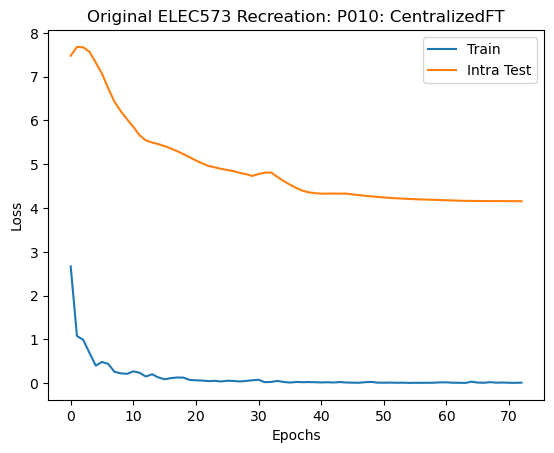

In [11]:
plot_train_test_curves(originalELEC573FT_data_dict_1_1['train_test_logs_list'][0]['P010'], "Original ELEC573 Recreation: P010: CentralizedFT", print_acc=False, acc_keys=['ft_centralized_acc', None, None], log_keys=['ft_centralized_train_loss_log', 'ft_centralized_test_loss_log', None])

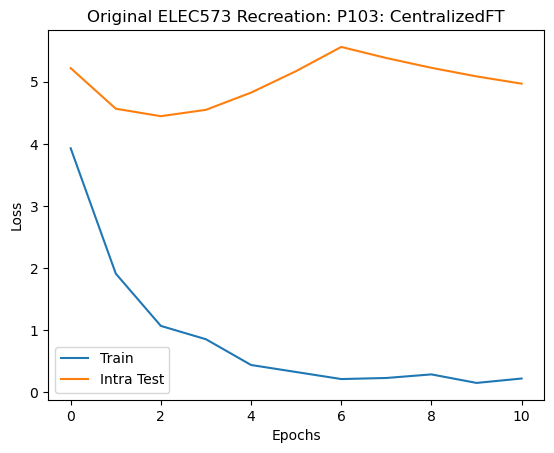

In [12]:
plot_train_test_curves(originalELEC573FT_data_dict_1_1['train_test_logs_list'][0]['P103'], "Original ELEC573 Recreation: P103: CentralizedFT", print_acc=False, acc_keys=['ft_centralized_acc', None, None], log_keys=['ft_centralized_train_loss_log', 'ft_centralized_test_loss_log', None])

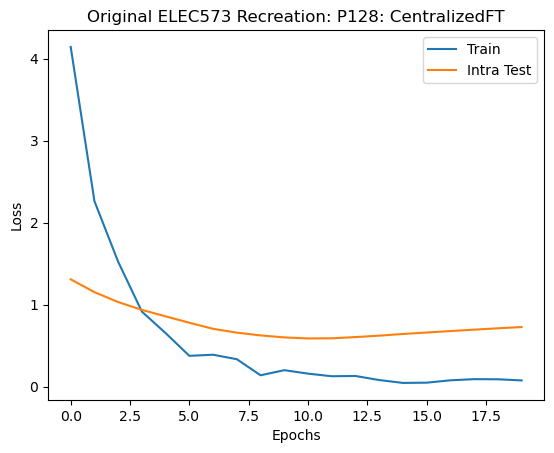

In [13]:
plot_train_test_curves(originalELEC573FT_data_dict_1_1['train_test_logs_list'][0]['P128'], "Original ELEC573 Recreation: P128: CentralizedFT", print_acc=False, acc_keys=['ft_centralized_acc', None, None], log_keys=['ft_centralized_train_loss_log', 'ft_centralized_test_loss_log', None])

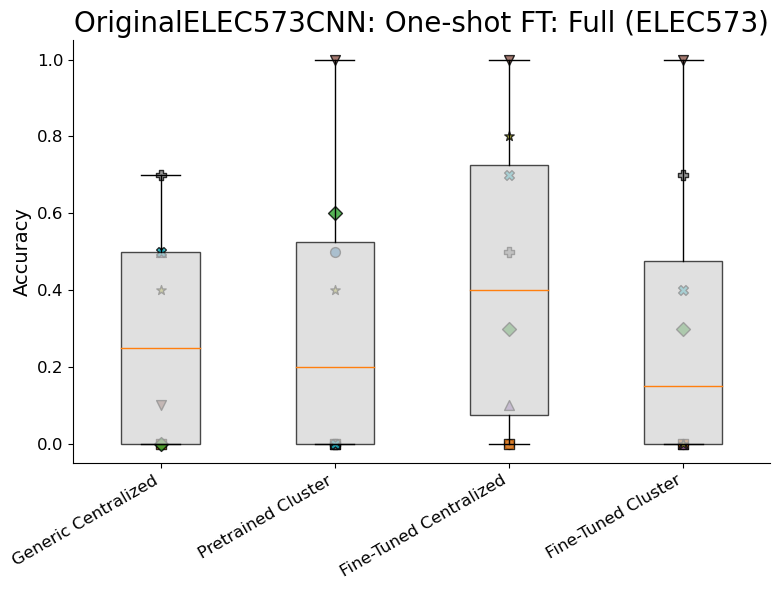

In [14]:
plot_model_acc_boxplots(originalELEC573FT_data_dict_1_1, my_title=f"{MODEL_STR}: One-shot FT: Full (ELEC573)", save_fig=False, plot_save_name=f"Final_{MODEL_STR}_Acc_1TA_1TT", 
                            data_keys=['centralized_acc_data', 'pretrained_cluster_acc_data', 'ft_centralized_acc_data', 'ft_cluster_acc_data'],
                            labels=['Generic Centralized', 'Pretrained Cluster', 'Fine-Tuned Centralized', 'Fine-Tuned Cluster'])
    

> FT1: Progressive Layer Unfreezing

In [15]:
progunfreezingFT_data_dict_1_1 = finetuning_run(shared_trial_data_splits_lst, progunfreezingFT_config, pretrained_generic_model, nested_clus_model_dict)

PID P010, 1/8
FT P010_: Early stopping reached after 8 epochs
Cluster 17 had the highest accuracy (0.2)
FT P010_: Early stopping reached after 8 epochs
PID P103, 2/8
FT P103_: Early stopping reached after 8 epochs
Cluster 17 had the highest accuracy (0.1)
FT P103_: Early stopping reached after 8 epochs
PID P104, 3/8
FT P104_: Early stopping reached after 8 epochs
Cluster 45 had the highest accuracy (0.2)
FT P104_: Early stopping reached after 16 epochs
PID P108, 4/8
FT P108_: Early stopping reached after 8 epochs
Cluster 45 had the highest accuracy (0.3)
FT P108_: Early stopping reached after 8 epochs
PID P116, 5/8
FT P116_: Early stopping reached after 36 epochs
Cluster 49 had the highest accuracy (1.0)
FT P116_: Early stopping reached after 8 epochs
PID P125, 6/8
FT P125_: Early stopping reached after 8 epochs
Cluster 48 had the highest accuracy (1.0)
FT P125_: Early stopping reached after 8 epochs
PID P127, 7/8
FT P127_: Early stopping reached after 19 epochs
Cluster 46 had the high

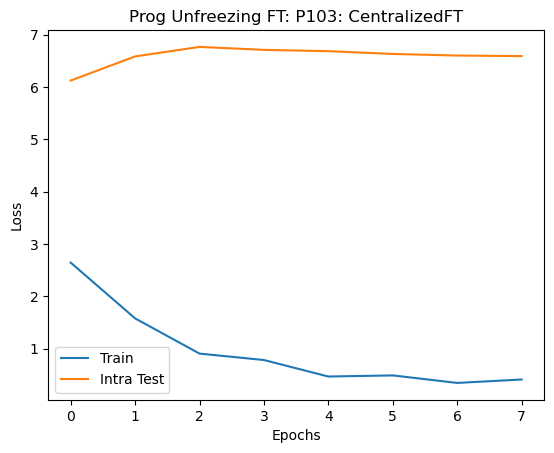

In [16]:
plot_train_test_curves(progunfreezingFT_data_dict_1_1['train_test_logs_list'][0]['P103'], "Prog Unfreezing FT: P103: CentralizedFT", print_acc=False, acc_keys=['ft_centralized_acc', None, None], log_keys=['ft_centralized_train_loss_log', 'ft_centralized_test_loss_log', None])

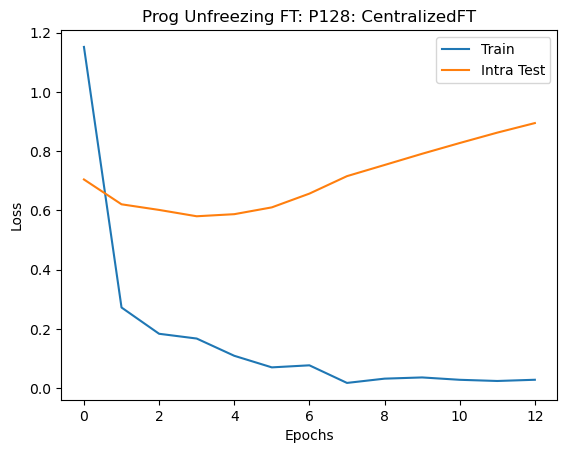

In [17]:
plot_train_test_curves(progunfreezingFT_data_dict_1_1['train_test_logs_list'][0]['P128'], "Prog Unfreezing FT: P128: CentralizedFT", print_acc=False, acc_keys=['ft_centralized_acc', None, None], log_keys=['ft_centralized_train_loss_log', 'ft_centralized_test_loss_log', None])

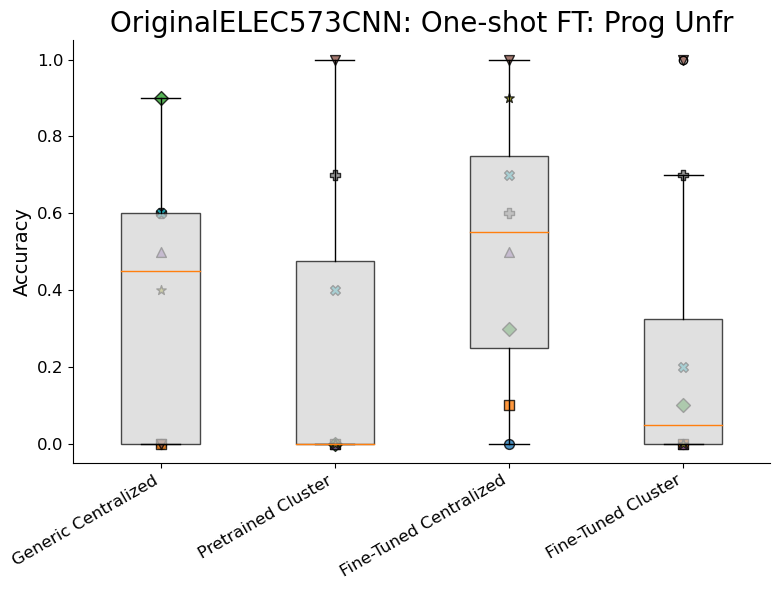

In [18]:
plot_model_acc_boxplots(progunfreezingFT_data_dict_1_1, my_title=f"{MODEL_STR}: One-shot FT: Prog Unfr", save_fig=False, plot_save_name=f"Final_{MODEL_STR}_Acc_1TA_1TT", 
                            data_keys=['centralized_acc_data', 'pretrained_cluster_acc_data', 'ft_centralized_acc_data', 'ft_cluster_acc_data'],
                            labels=['Generic Centralized', 'Pretrained Cluster', 'Fine-Tuned Centralized', 'Fine-Tuned Cluster'])
    

> FT2: Retraining full model weights

In [19]:
fullFT_data_dict_1_1 = finetuning_run(shared_trial_data_splits_lst, fullFT_config, pretrained_generic_model, nested_clus_model_dict)

PID P010, 1/8
FT P010_: Early stopping reached after 8 epochs
Cluster 17 had the highest accuracy (0.3)
FT P010_: Early stopping reached after 8 epochs
PID P103, 2/8
FT P103_: Early stopping reached after 8 epochs
Cluster 17 had the highest accuracy (0.1)
FT P103_: Early stopping reached after 8 epochs
PID P104, 3/8
FT P104_: Early stopping reached after 8 epochs
Cluster 45 had the highest accuracy (0.4)
FT P104_: Early stopping reached after 43 epochs
PID P108, 4/8
FT P108_: Early stopping reached after 10 epochs
Cluster 17 had the highest accuracy (0.2)
FT P108_: Early stopping reached after 9 epochs
PID P116, 5/8
FT P116_: Early stopping reached after 21 epochs
Cluster 49 had the highest accuracy (1.0)
FT P116_: Early stopping reached after 14 epochs
PID P125, 6/8
FT P125_: Early stopping reached after 8 epochs
Cluster 48 had the highest accuracy (1.0)
FT P125_: Early stopping reached after 8 epochs
PID P127, 7/8
FT P127_: Early stopping reached after 17 epochs
Cluster 46 had the hi

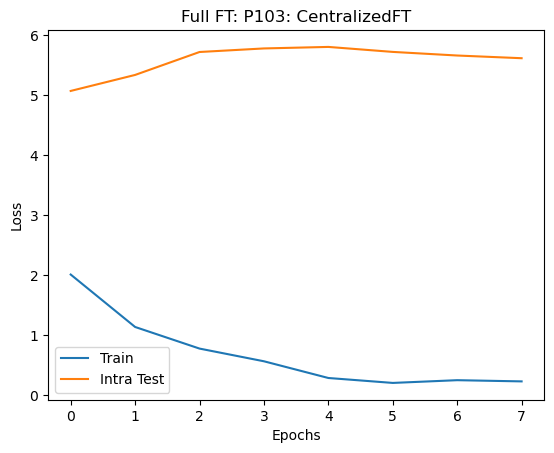

In [20]:
plot_train_test_curves(fullFT_data_dict_1_1['train_test_logs_list'][0]['P103'], "Full FT: P103: CentralizedFT", print_acc=False, acc_keys=['ft_centralized_acc', None, None], log_keys=['ft_centralized_train_loss_log', 'ft_centralized_test_loss_log', None])

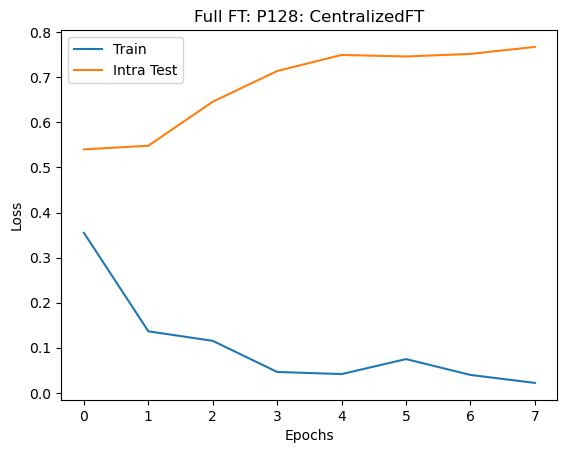

In [21]:
plot_train_test_curves(fullFT_data_dict_1_1['train_test_logs_list'][0]['P128'], "Full FT: P128: CentralizedFT", print_acc=False, acc_keys=['ft_centralized_acc', None, None], log_keys=['ft_centralized_train_loss_log', 'ft_centralized_test_loss_log', None])

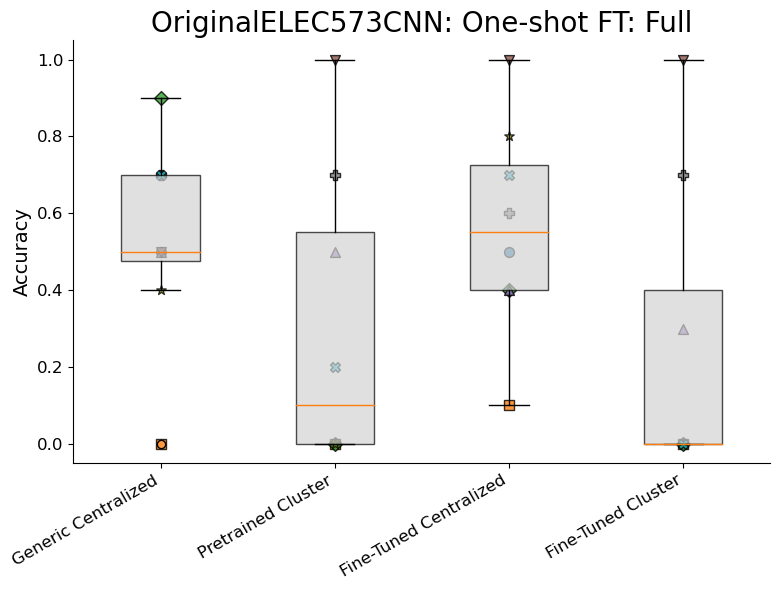

In [22]:
plot_model_acc_boxplots(fullFT_data_dict_1_1, my_title=f"{MODEL_STR}: One-shot FT: Full", save_fig=False, plot_save_name=f"Final_{MODEL_STR}_Acc_1TA_1TT", 
                            data_keys=['centralized_acc_data', 'pretrained_cluster_acc_data', 'ft_centralized_acc_data', 'ft_cluster_acc_data'],
                            labels=['Generic Centralized', 'Pretrained Cluster', 'Fine-Tuned Centralized', 'Fine-Tuned Cluster'])
    

> FT3: Freeze CNN, FT LSTM+Dense

In [23]:
freezeCNNFT_data_dict_1_1 = finetuning_run(shared_trial_data_splits_lst, freezeCNNFT_config, pretrained_generic_model, nested_clus_model_dict)

PID P010, 1/8
FT P010_: Early stopping reached after 8 epochs
Cluster 17 had the highest accuracy (0.2)
FT P010_: Early stopping reached after 30 epochs
PID P103, 2/8
FT P103_: Early stopping reached after 22 epochs
Cluster 46 had the highest accuracy (0.2)
FT P103_: Early stopping reached after 17 epochs
PID P104, 3/8
FT P104_: Early stopping reached after 8 epochs
Cluster 45 had the highest accuracy (1.0)
FT P104_: Early stopping reached after 8 epochs
PID P108, 4/8
FT P108_: Early stopping reached after 8 epochs
Cluster 17 had the highest accuracy (0.2)
FT P108_: Early stopping reached after 8 epochs
PID P116, 5/8
FT P116_: Early stopping reached after 15 epochs
Cluster 49 had the highest accuracy (1.0)
FT P116_: Early stopping reached after 8 epochs
PID P125, 6/8
FT P125_: Early stopping reached after 24 epochs
Cluster 48 had the highest accuracy (1.0)
FT P125_: Early stopping reached after 8 epochs
PID P127, 7/8
FT P127_: Early stopping reached after 9 epochs
Cluster 46 had the hi

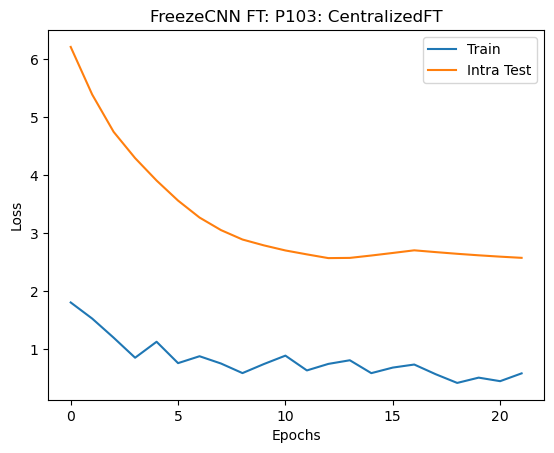

In [24]:
plot_train_test_curves(freezeCNNFT_data_dict_1_1['train_test_logs_list'][0]['P103'], "FreezeCNN FT: P103: CentralizedFT", print_acc=False, acc_keys=['ft_centralized_acc', None, None], log_keys=['ft_centralized_train_loss_log', 'ft_centralized_test_loss_log', None])

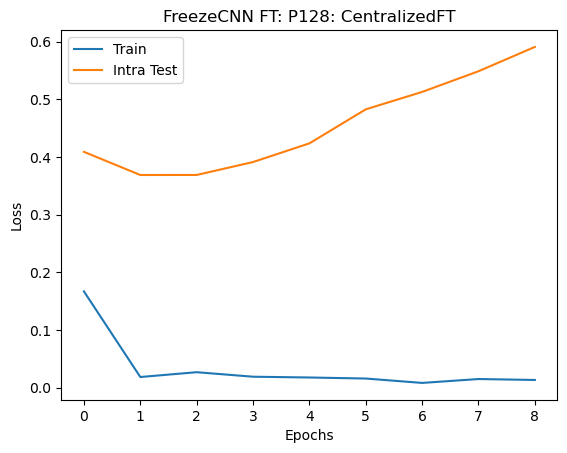

In [25]:
plot_train_test_curves(freezeCNNFT_data_dict_1_1['train_test_logs_list'][0]['P128'], "FreezeCNN FT: P128: CentralizedFT", print_acc=False, acc_keys=['ft_centralized_acc', None, None], log_keys=['ft_centralized_train_loss_log', 'ft_centralized_test_loss_log', None])

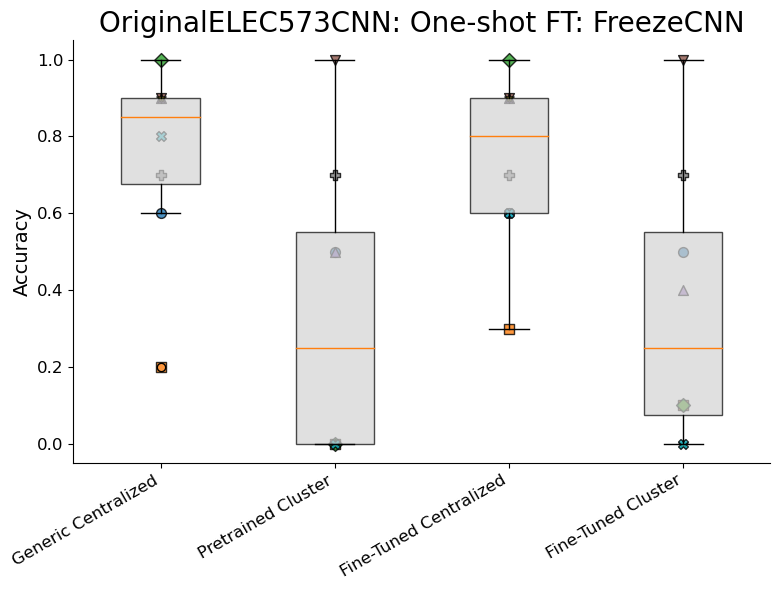

In [26]:
plot_model_acc_boxplots(freezeCNNFT_data_dict_1_1, my_title=f"{MODEL_STR}: One-shot FT: FreezeCNN", save_fig=False, plot_save_name=f"Final_{MODEL_STR}_Acc_1TA_1TT", 
                            data_keys=['centralized_acc_data', 'pretrained_cluster_acc_data', 'ft_centralized_acc_data', 'ft_cluster_acc_data'],
                            labels=['Generic Centralized', 'Pretrained Cluster', 'Fine-Tuned Centralized', 'Fine-Tuned Cluster'])
    

> FT4: Freeze all layers but final dense layer

In [27]:
pretrained_generic_model

DynamicCNN(
  (relu): ReLU()
  (softmax): Softmax(dim=1)
  (conv_layers): ModuleList(
    (0): Sequential(
      (0): Conv1d(1, 32, kernel_size=(5,), stride=(2,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv1d(32, 64, kernel_size=(5,), stride=(2,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): Conv1d(64, 128, kernel_size=(5,), stride=(2,))
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (global_pool): AdaptiveAvgPool1d(output_size=1)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [28]:
freezeallbutdenseFT_data_dict_1_1 = finetuning_run(shared_trial_data_splits_lst, freezeallbutdenseFT_config, pretrained_generic_model, nested_clus_model_dict)

PID P010, 1/8
FT P010_: Early stopping reached after 16 epochs
Cluster 17 had the highest accuracy (0.7)
FT P010_: Early stopping reached after 32 epochs
PID P103, 2/8
FT P103_: Early stopping reached after 52 epochs
Cluster 46 had the highest accuracy (0.2)
FT P103_: Early stopping reached after 30 epochs
PID P104, 3/8
FT P104_: Early stopping reached after 12 epochs
Cluster 45 had the highest accuracy (1.0)
FT P104_: Early stopping reached after 8 epochs
PID P108, 4/8
FT P108_: Early stopping reached after 8 epochs
Cluster 17 had the highest accuracy (0.2)
FT P108_: Early stopping reached after 17 epochs
PID P116, 5/8
FT P116_: Early stopping reached after 25 epochs
Cluster 49 had the highest accuracy (1.0)
FT P116_: Early stopping reached after 8 epochs
PID P125, 6/8
FT P125_: Early stopping reached after 23 epochs
Cluster 48 had the highest accuracy (1.0)
FT P125_: Early stopping reached after 8 epochs
PID P127, 7/8
FT P127_: Early stopping reached after 17 epochs
Cluster 46 had th

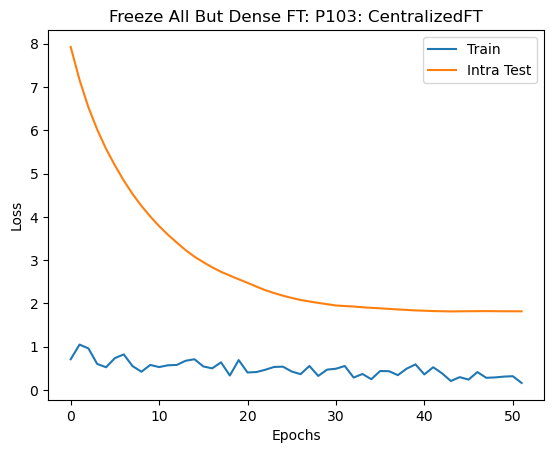

In [29]:
plot_train_test_curves(freezeallbutdenseFT_data_dict_1_1['train_test_logs_list'][0]['P103'], "Freeze All But Dense FT: P103: CentralizedFT", print_acc=False, acc_keys=['ft_centralized_acc', None, None], log_keys=['ft_centralized_train_loss_log', 'ft_centralized_test_loss_log', None])

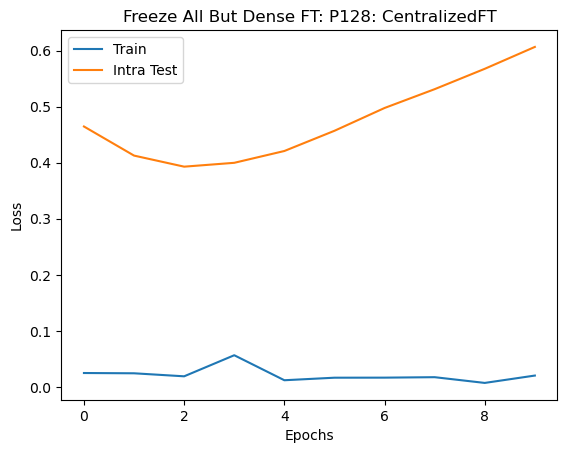

In [30]:
plot_train_test_curves(freezeallbutdenseFT_data_dict_1_1['train_test_logs_list'][0]['P128'], "Freeze All But Dense FT: P128: CentralizedFT", print_acc=False, acc_keys=['ft_centralized_acc', None, None], log_keys=['ft_centralized_train_loss_log', 'ft_centralized_test_loss_log', None])

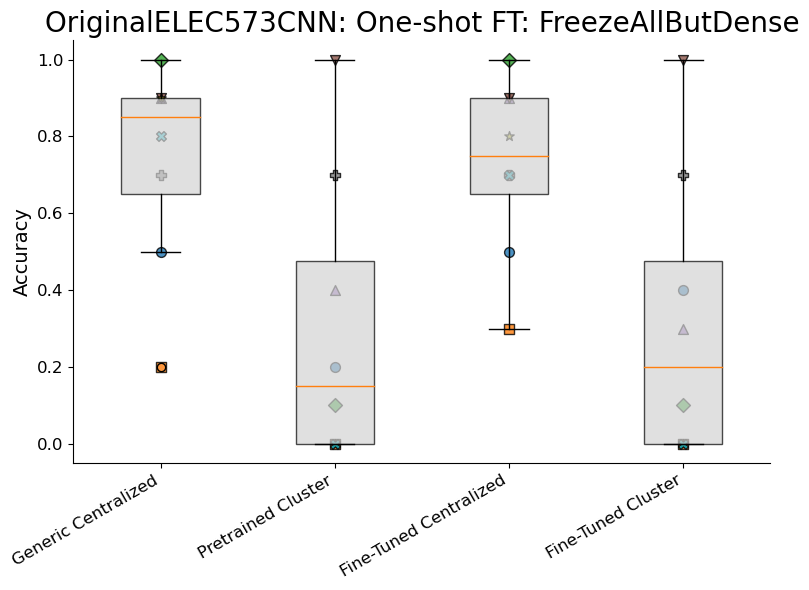

In [31]:
plot_model_acc_boxplots(freezeallbutdenseFT_data_dict_1_1, my_title=f"{MODEL_STR}: One-shot FT: FreezeAllButDense", save_fig=False, plot_save_name=f"Final_{MODEL_STR}_Acc_1TA_1TT", 
                            data_keys=['centralized_acc_data', 'pretrained_cluster_acc_data', 'ft_centralized_acc_data', 'ft_cluster_acc_data'],
                            labels=['Generic Centralized', 'Pretrained Cluster', 'Fine-Tuned Centralized', 'Fine-Tuned Cluster'])
    